In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
plt.rcParams['figure.figsize'] = [17, 5]

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score


from scipy import stats
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# load data
df_sub1 = pd.read_csv('./labeled_data/sub1label.csv')
df_sub2 = pd.read_csv('./labeled_data/sub2label.csv')
df_sub3 = pd.read_csv('./labeled_data/sub3label.csv')

# drop unneccessary columns
df_sub1.drop('Unnamed: 0', axis=1, inplace=True)
df_sub2.drop('Unnamed: 0', axis=1, inplace=True)
df_sub3.drop('Unnamed: 0', axis=1, inplace=True)

df_subjects = pd.concat([df_sub1, df_sub2, df_sub3], keys=['s1', 's2', 's3'])

df_true = df_subjects.loc[df_subjects['label'] == 1]
df_false = df_subjects.loc[df_subjects['label'] == 0]

df_subjects.head(10)

Time  A/M Other   A/M  delta     theta  low_alpha  high_alpha  \
s1 0  4.880859      -44.0  51.0   74.0  567109.0    74006.0     38310.0   
   1  4.882812      -38.0  51.0   74.0  567109.0    74006.0     38310.0   
   2  4.884766      -27.0  51.0   74.0  567109.0    74006.0     38310.0   
   3  4.886719      -25.0  51.0   74.0  567109.0    74006.0     38310.0   
   4  4.888672      -19.0  51.0   74.0  567109.0    74006.0     38310.0   
   5  4.890625      -22.0  51.0   74.0  567109.0    74006.0     38310.0   
   6  4.892578      -21.0  51.0   74.0  567109.0    74006.0     38310.0   
   7  4.894531       -8.0  51.0   74.0  567109.0    74006.0     38310.0   
   8  4.896484        4.0  51.0   74.0  567109.0    74006.0     38310.0   
   9  4.898438        7.0  51.0   74.0  567109.0    74006.0     38310.0   

      low_beta  high_beta  low_gamma  mid_gamma  blink_stimulation  \
s1 0    6806.0     9837.0    10228.0     1916.0              849.0   
   1    6806.0     9837.0    10228.0     1916.0              849.0   
   2    6806.0     9837.0    10228.0     1916.0              849.0   
   3    6806.0     9837.0    10228.0     1916.0              849.0   
   4    6806.0     9837.0    10228.0     1916.0              849.0   
   5    6806.0     9837.0    10228.0     1916.0              849.0   
   6    6806.0     9837.0    10228.0     1916.0              849.0   
   7    6806.0     9837.0    10228.0     1916.0              849.0   
   8    6806.0     9837.0    10228.0     1916.0              849.0   
   9    6806.0     9837.0    10228.0     1916.0              849.0   

      blink_strength  label  
s1 0    3.783506e-44      0  
   1    4.764415e-43      0  
   2    3.363116e-44      0  
   3    4.203895e-44      0  
   4    0.000000e+00      0  
   5    1.386716e-38      0  
   6    4.049753e-43      0  
   7    1.191104e-43      0  
   8    3.783506e-44      0  
   9    4.764415e-43      0

In [3]:
#df_true = df_true[np.abs(df_true['high_beta']-df_true['high_beta'].mean())<=(3*df_true['high_beta'].std())]
#df_false = df_false[np.abs(df_false['high_beta']-df_false['high_beta'].mean())<=(3*df_false['high_beta'].std())]

cols = list(df_subjects)
for c in cols:
    df_true = df_true[np.abs(df_true[c]-df_true[c].mean())<=(3*df_true[c].std())]
    df_false = df_false[np.abs(df_false[c]-df_false[c].mean())<=(3*df_false[c].std())]
    df_subjects = df_subjects[np.abs(df_subjects[c]-df_subjects[c].mean())<=(3*df_subjects[c].std())]

In [4]:
print(df_subjects.shape)

(109057, 14)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


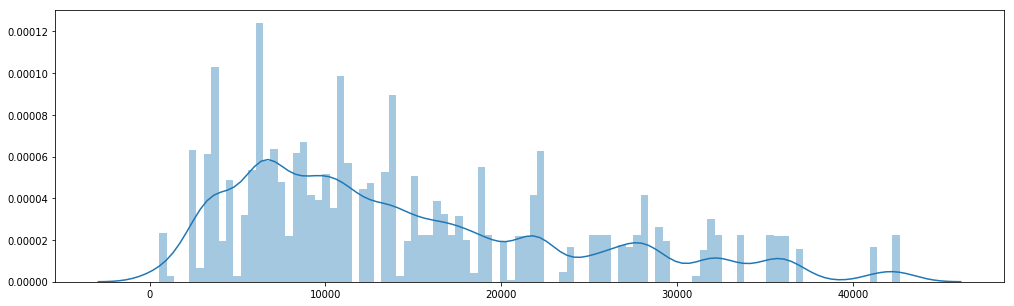

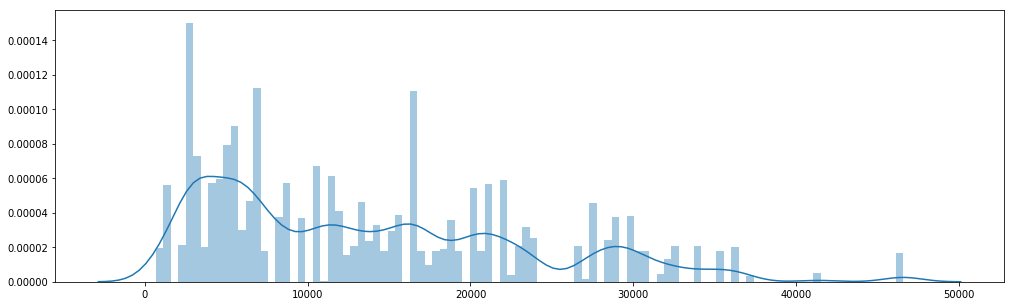

In [5]:
sns.distplot(df_true['high_beta'].values, bins=100);
plt.show()
sns.distplot(df_false['high_beta'].values, bins=100);
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


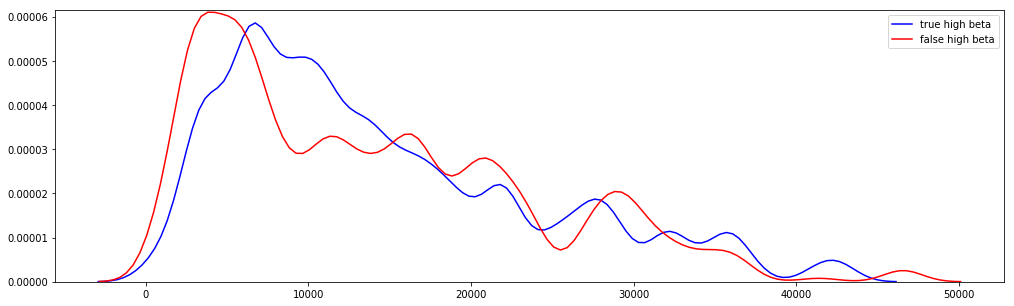

In [23]:
sns.distplot(df_true['high_beta'].values, hist=False, color="blue", label="true high beta");
sns.distplot(df_false['high_beta'].values, hist=False, color="red", label="false high beta");
#ax.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


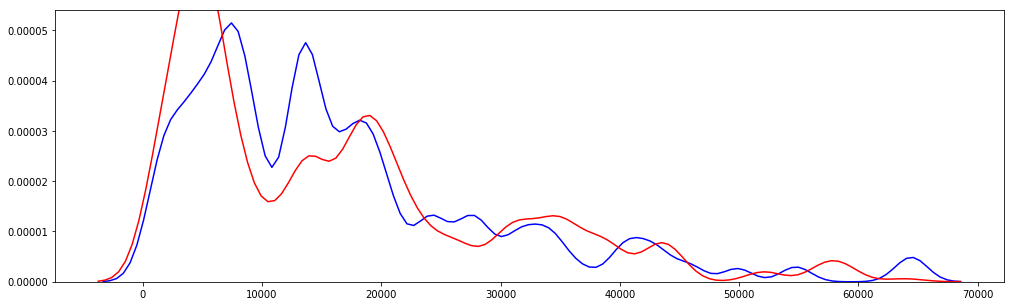

In [7]:
sns.distplot(df_true['low_beta'].values, hist=False, color="blue");
sns.distplot(df_false['low_beta'].values, hist=False, color="red");
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


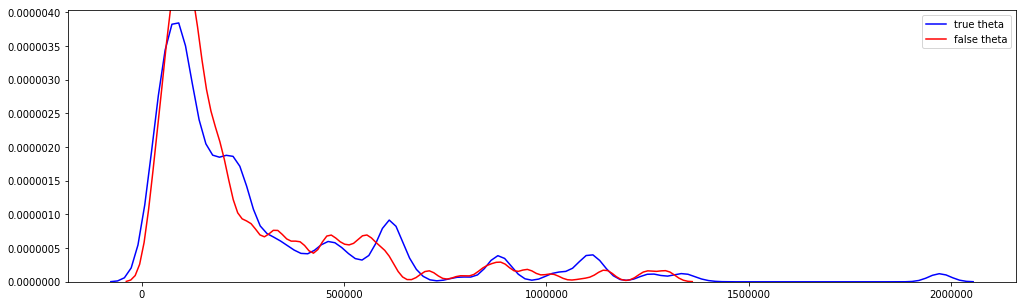

In [24]:
sns.distplot(df_true['theta'].values, hist=False, color="blue", label="true theta");
sns.distplot(df_false['theta'].values, hist=False, color="red", label="false theta");
plt.show()

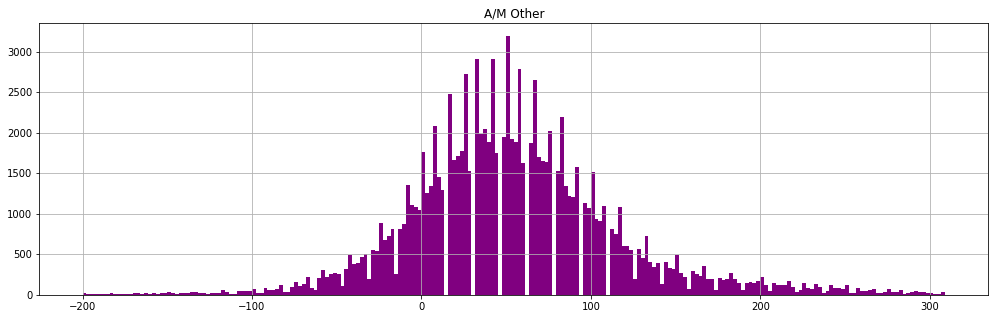

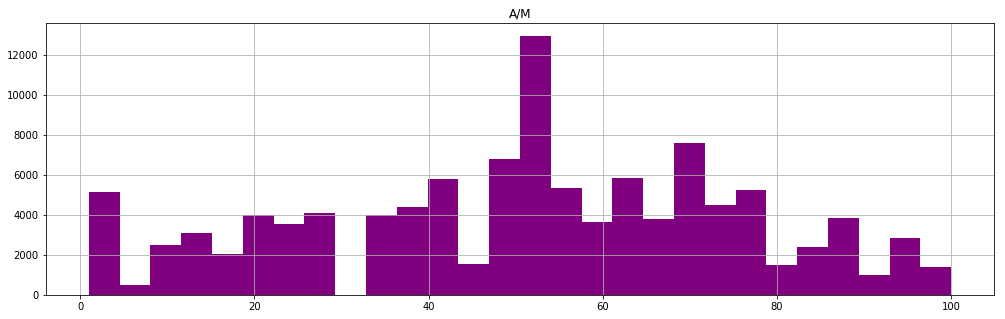

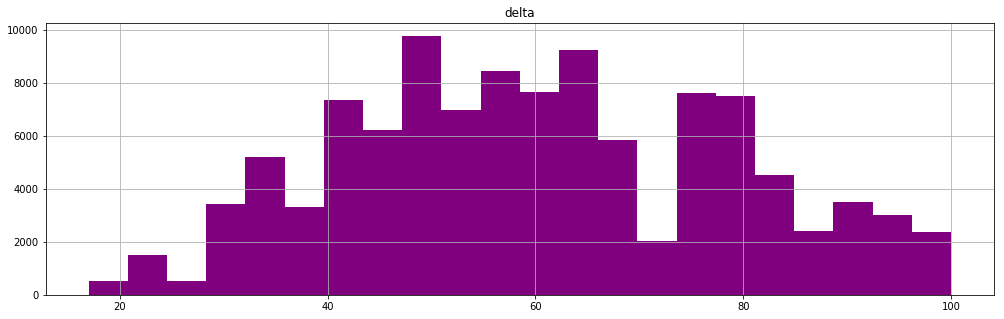

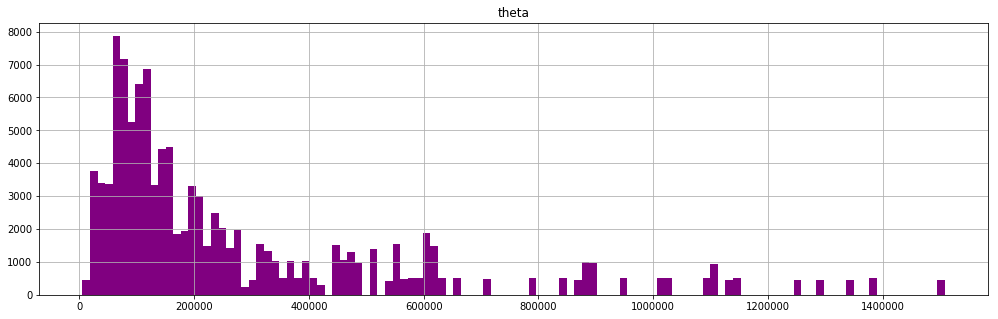

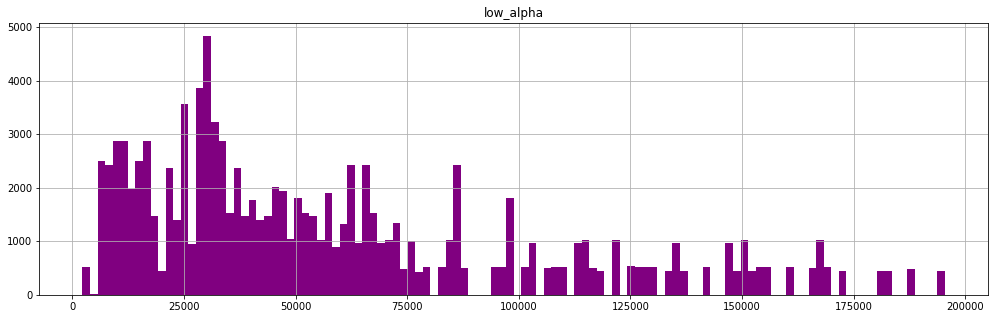

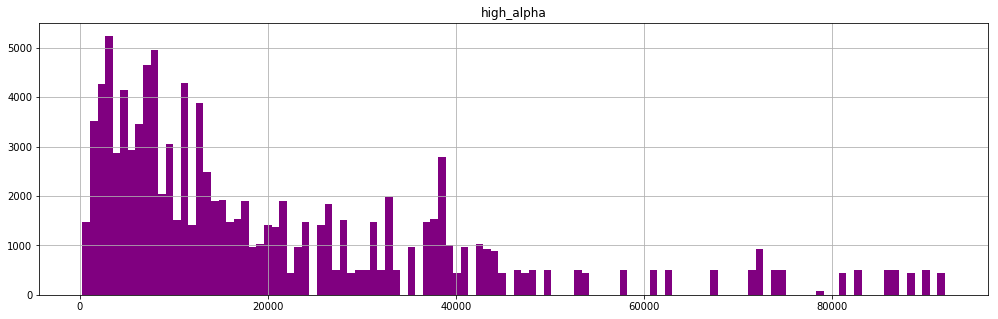

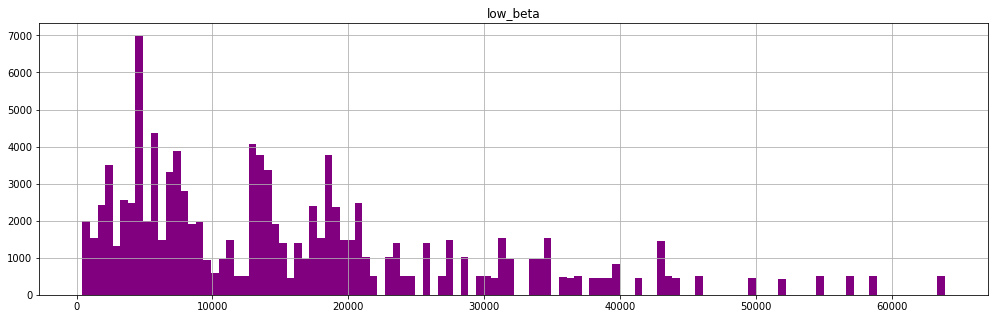

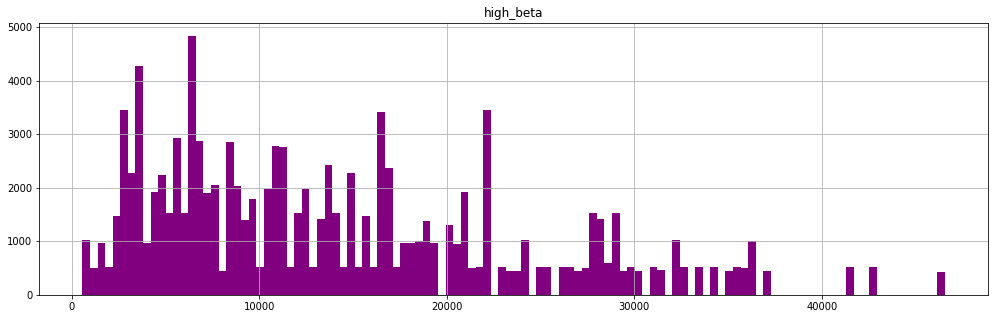

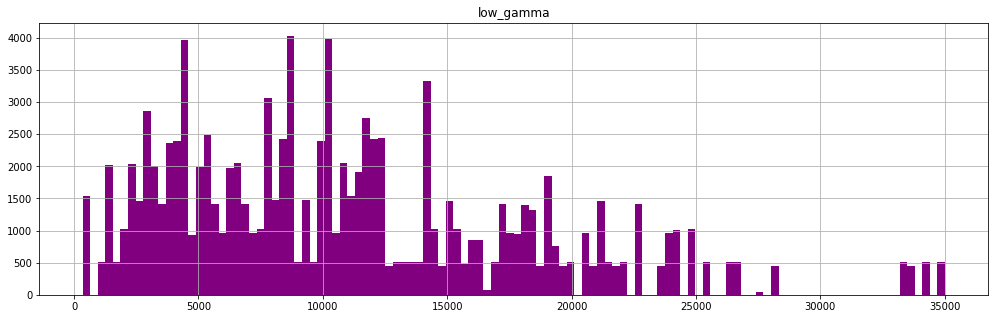

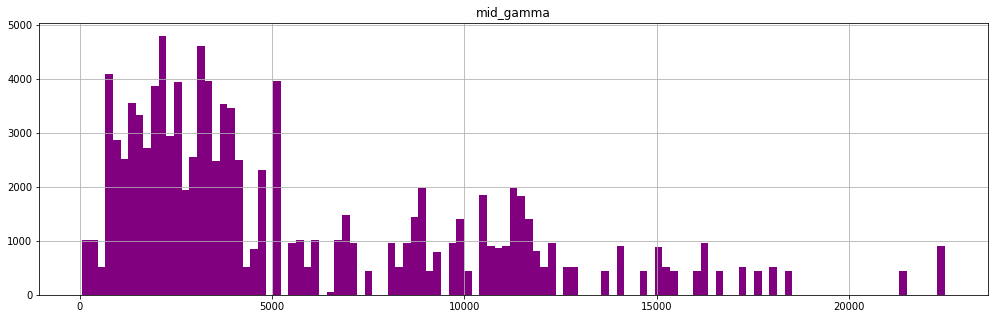

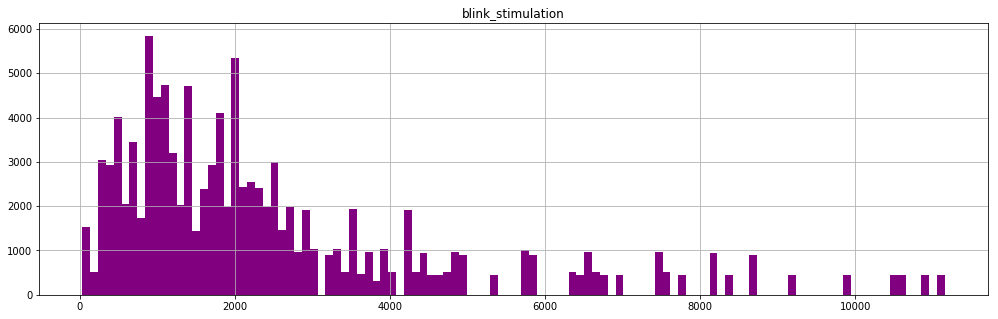

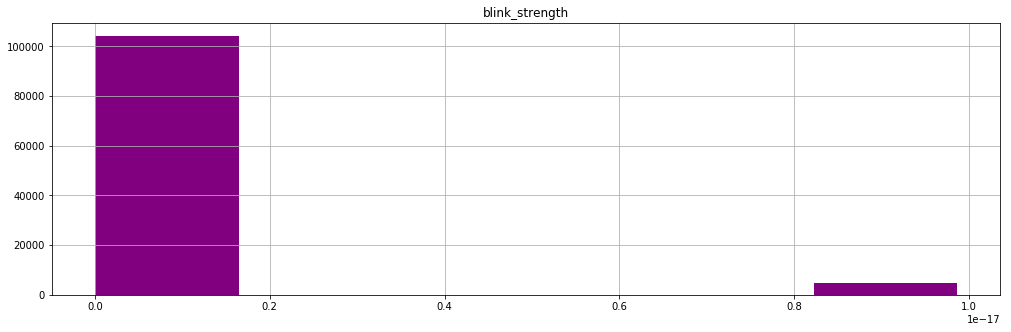

In [9]:
# plot all features vs time
cols = list(df_subjects)
for c in cols:
    if (c == "Time") or (c == "label"):
        continue
    else:
        unique = df_subjects[c].nunique()
        unique /= 2
        df_subjects.hist(column=c, bins=round(unique), color="purple")
plt.show()

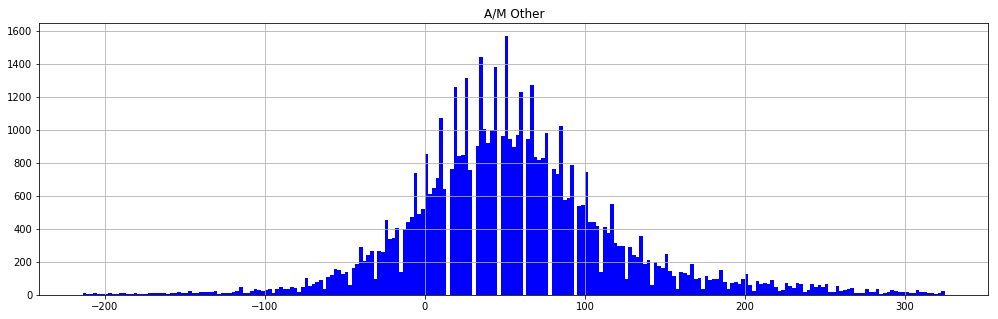

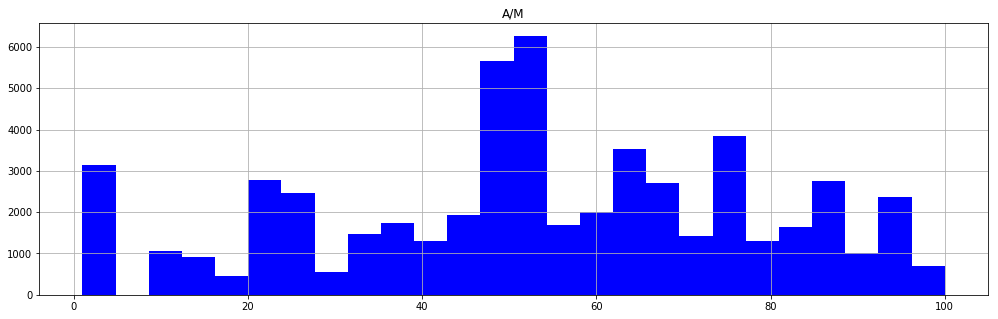

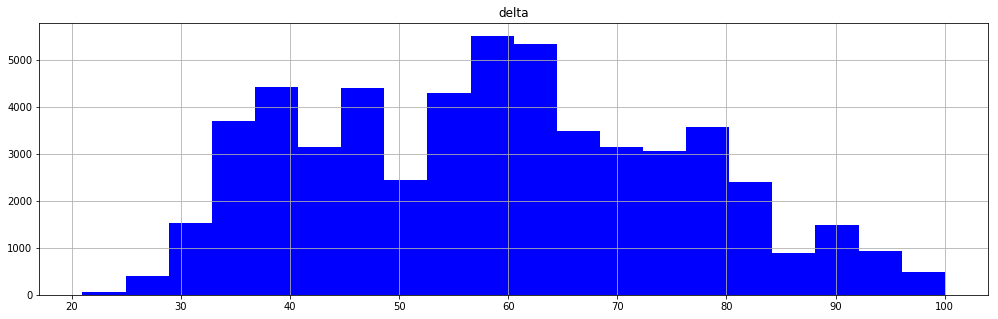

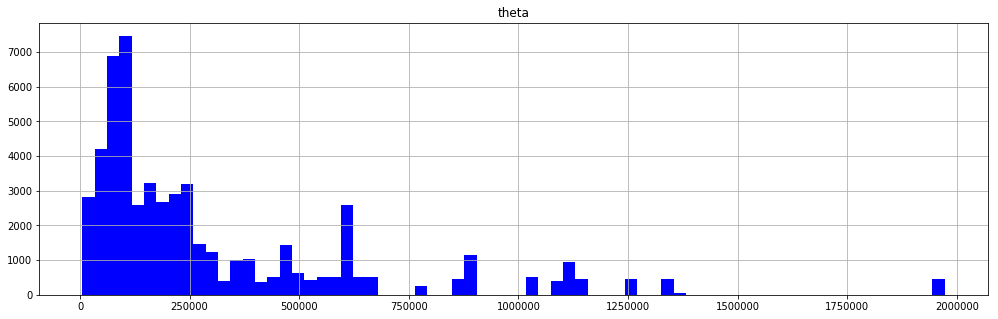

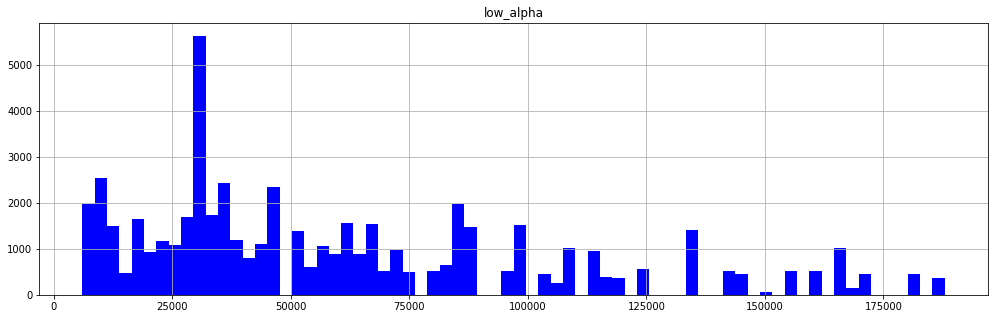

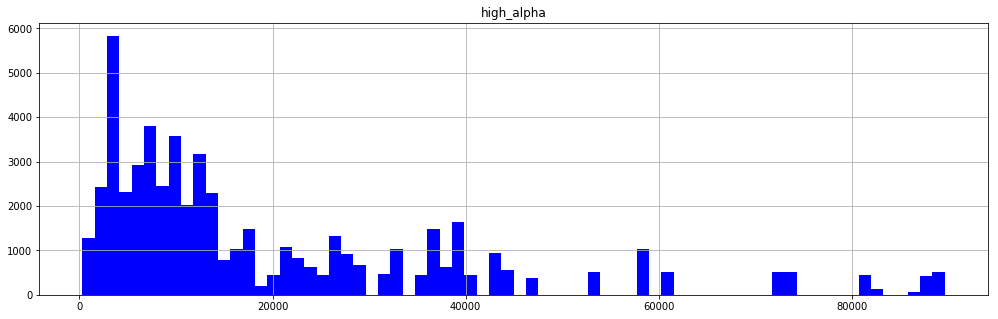

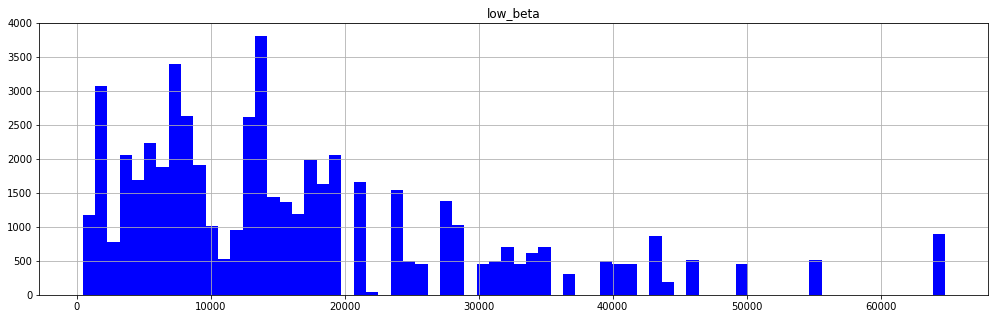

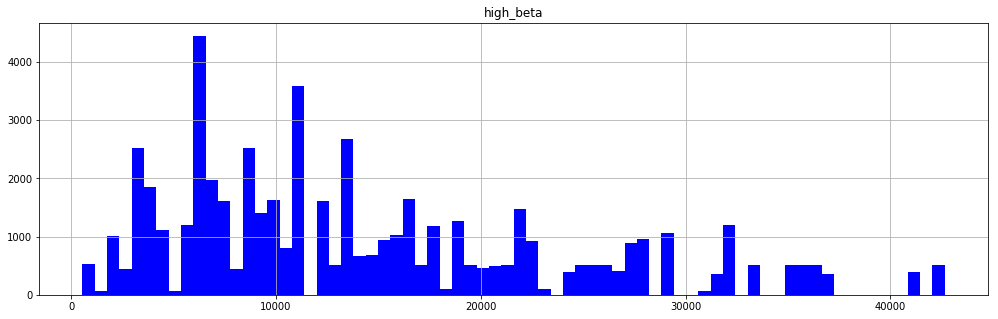

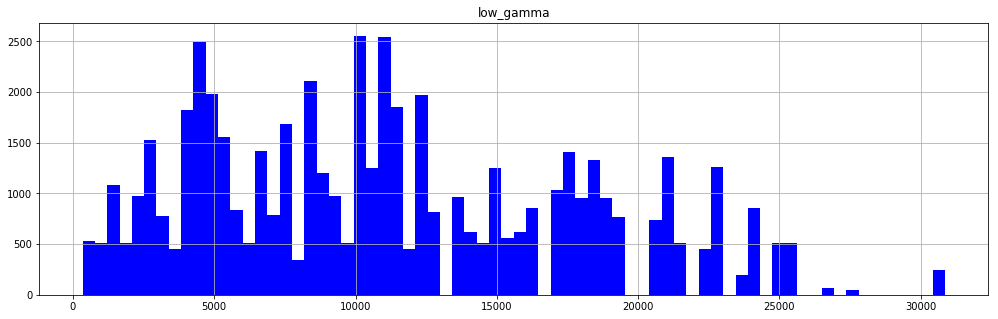

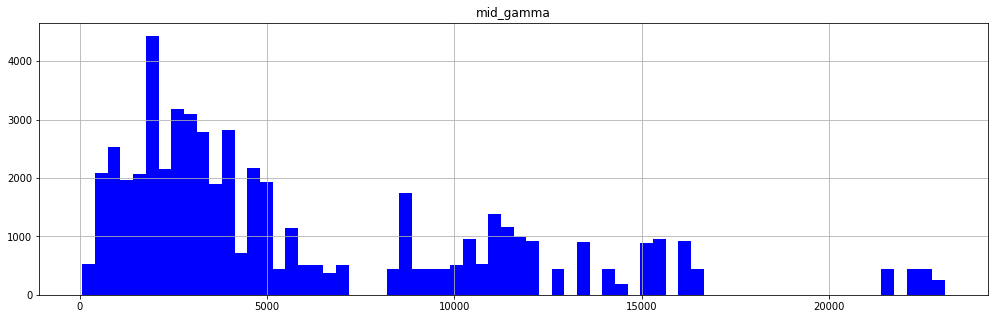

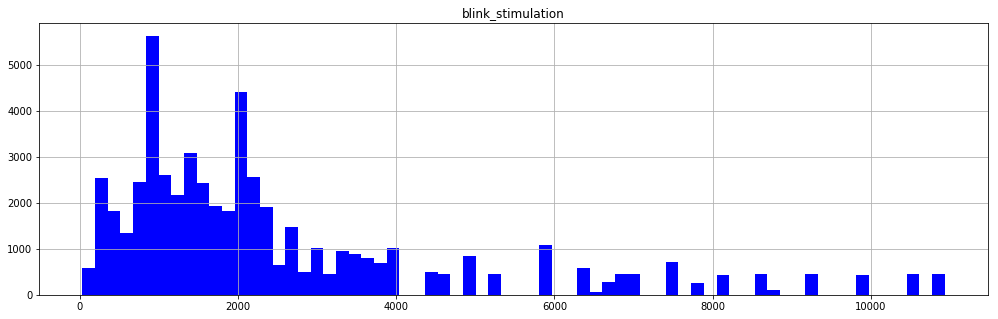

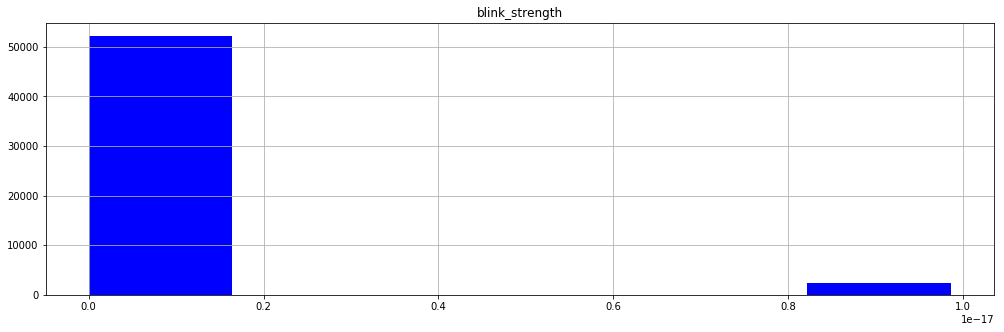

In [10]:
# plot all features vs time
cols = list(df_true)
for c in cols:
    if (c == "Time") or (c == "label"):
        continue
    else:
        unique = df_true[c].nunique()
        unique /= 2
        df_true.hist(column=c, bins=round(unique), color="blue")
plt.show()

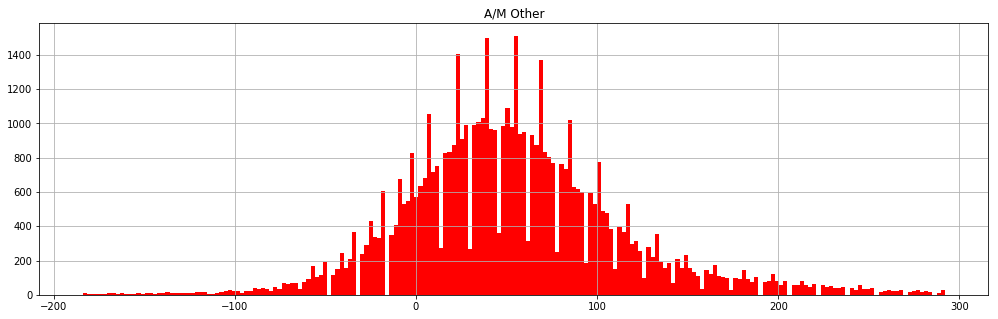

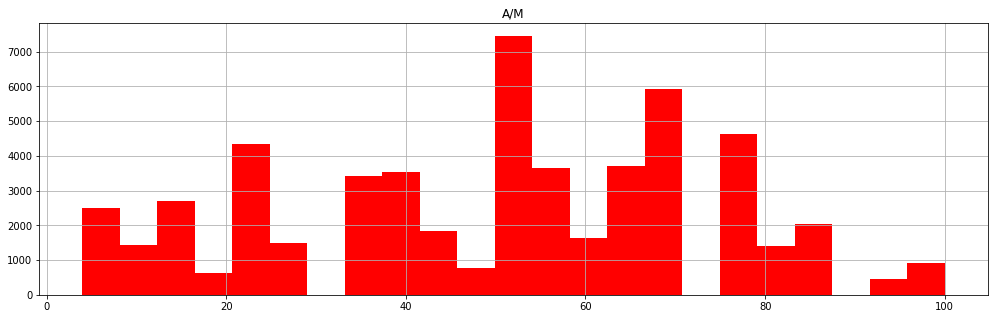

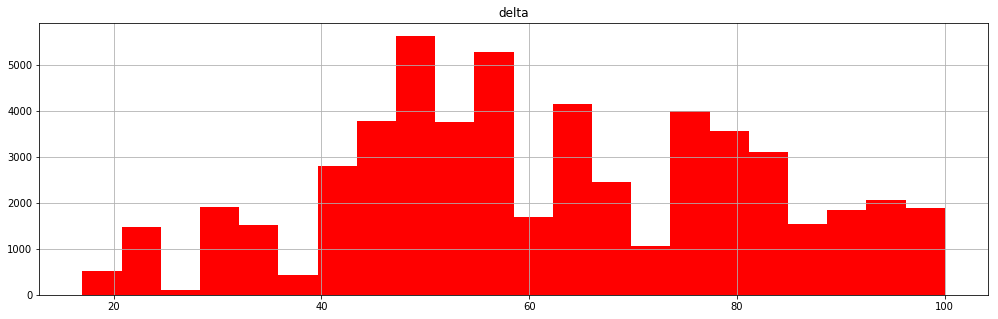

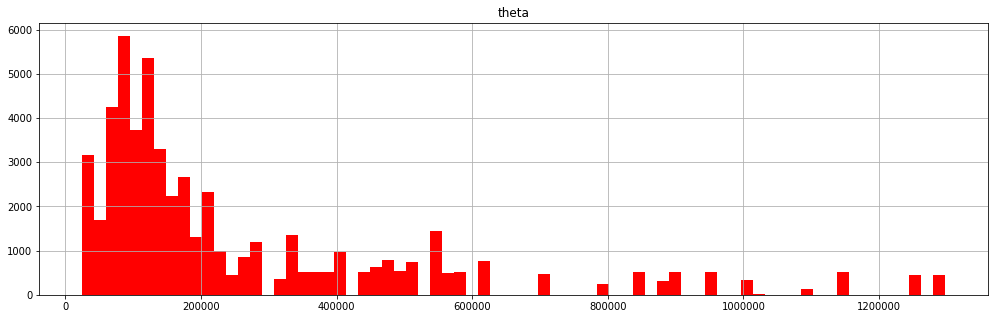

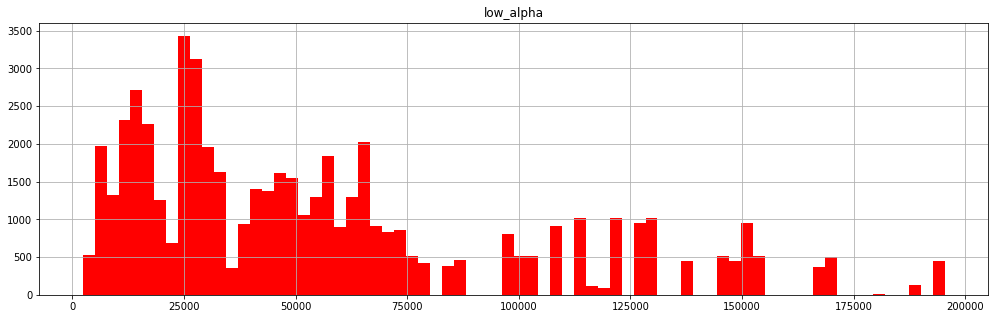

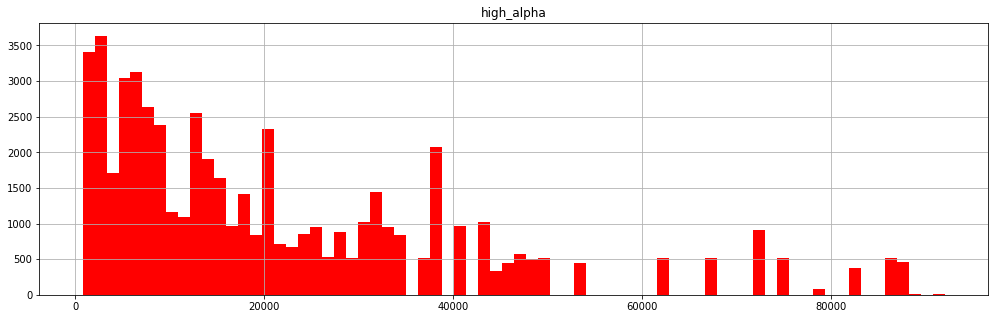

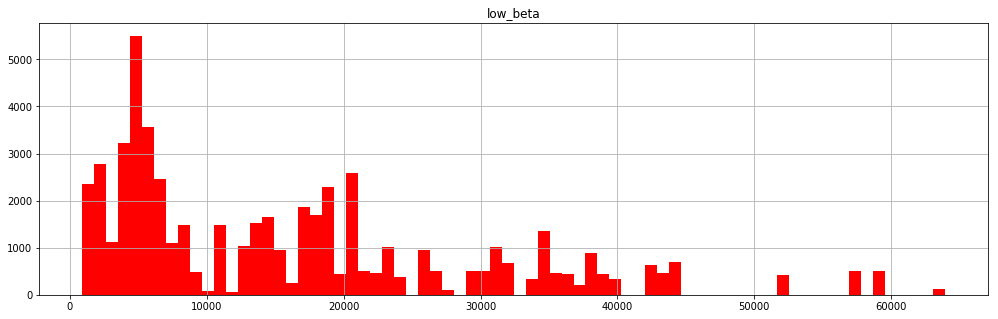

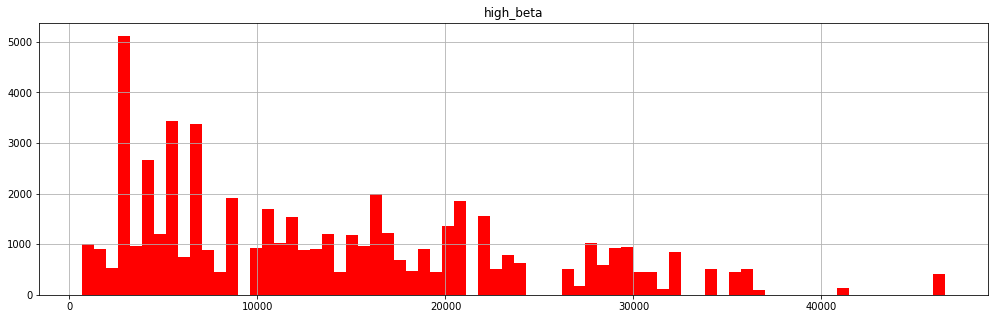

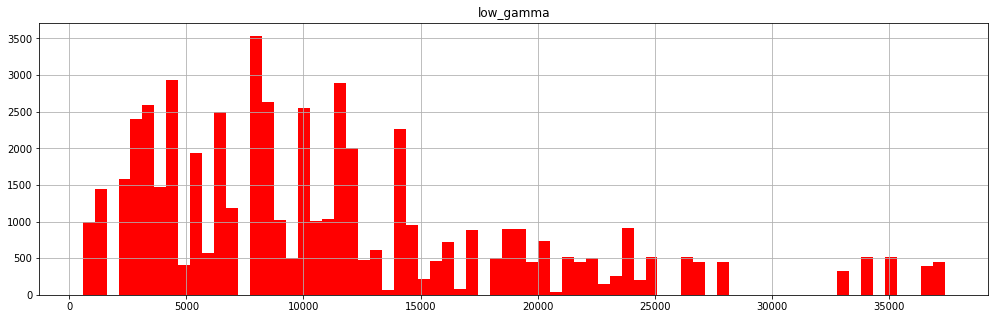

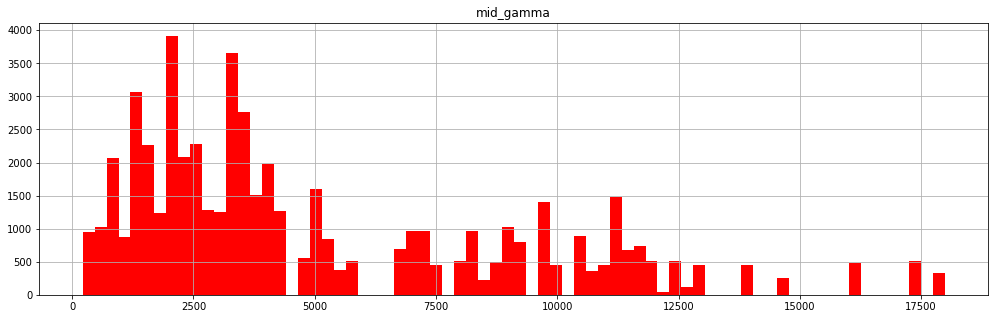

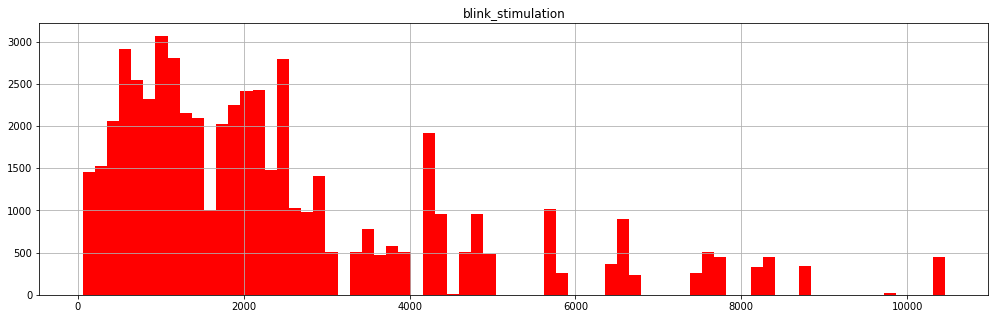

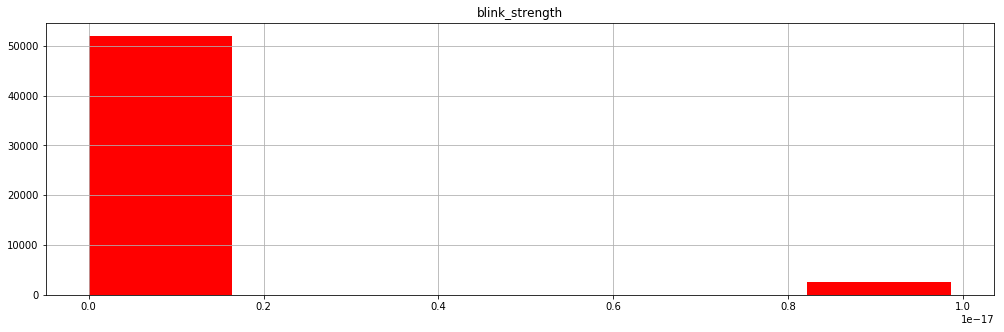

In [11]:
# plot all features vs time
cols = list(df_false)
for c in cols:
    if (c == "Time") or (c == "label"):
        continue
    else:
        unique = df_false[c].nunique()
        unique /= 2
        df_false.hist(column=c, bins=round(unique), color="red")
plt.show()

In [12]:
# remove time from dfs
df_subjects.drop('Time', axis=1, inplace=True)
#df_sub2.drop('Time', axis=1, inplace=True)
cols = list(df_subjects)
df_subjects.head()

A/M Other   A/M  delta     theta  low_alpha  high_alpha  low_beta  \
s1 0      -44.0  51.0   74.0  567109.0    74006.0     38310.0    6806.0   
   1      -38.0  51.0   74.0  567109.0    74006.0     38310.0    6806.0   
   2      -27.0  51.0   74.0  567109.0    74006.0     38310.0    6806.0   
   3      -25.0  51.0   74.0  567109.0    74006.0     38310.0    6806.0   
   4      -19.0  51.0   74.0  567109.0    74006.0     38310.0    6806.0   

      high_beta  low_gamma  mid_gamma  blink_stimulation  blink_strength  \
s1 0     9837.0    10228.0     1916.0              849.0    3.783506e-44   
   1     9837.0    10228.0     1916.0              849.0    4.764415e-43   
   2     9837.0    10228.0     1916.0              849.0    3.363116e-44   
   3     9837.0    10228.0     1916.0              849.0    4.203895e-44   
   4     9837.0    10228.0     1916.0              849.0    0.000000e+00   

      label  
s1 0      0  
   1      0  
   2      0  
   3      0  
   4      0

In [13]:
# correlation between features
corr = df_sub1.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time,A/M Other,A/M,delta,theta,low_alpha,high_alpha,low_beta,high_beta,low_gamma,mid_gamma,blink_stimulation,blink_strength,label
Time,1,-0.0029385,-0.566802,-0.183148,-0.0968233,-0.071515,0.0522462,-0.0661854,0.110727,-0.112974,0.0108849,-0.106352,7.51205e-05,0.0064466
A/M Other,-0.0029385,1,-0.00605894,-0.0268821,0.0887751,0.0204623,0.00620494,0.00180199,-0.0142576,0.0101362,0.0148469,-0.00110372,0.000612347,0.00618995
A/M,-0.566802,-0.00605894,1,0.0108026,-0.0102214,-0.185199,-0.141859,-0.0159622,-0.19012,0.229076,0.0907695,0.0875686,-7.53856e-05,-0.0254062
delta,-0.183148,-0.0268821,0.0108026,1,0.0535211,0.040348,0.381411,0.233569,0.0461065,0.211629,0.200192,0.117102,-9.62135e-05,0.00133966
theta,-0.0968233,0.0887751,-0.0102214,0.0535211,1,0.354826,0.336972,0.152304,-0.103322,0.334542,0.355093,0.0495999,-3.83525e-05,0.09866
low_alpha,-0.071515,0.0204623,-0.185199,0.040348,0.354826,1,0.405363,0.275332,0.251183,0.503354,0.331643,0.336895,-3.0229e-05,0.0312225
high_alpha,0.0522462,0.00620494,-0.141859,0.381411,0.336972,0.405363,1,0.24695,0.120404,0.40898,0.263143,0.173823,7.9997e-05,0.014214
low_beta,-0.0661854,0.00180199,-0.0159622,0.233569,0.152304,0.275332,0.24695,1,0.428649,0.270261,0.18851,0.345108,-1.93429e-06,0.142636
high_beta,0.110727,-0.0142576,-0.19012,0.0461065,-0.103322,0.251183,0.120404,0.428649,1,0.243076,0.217975,0.345842,9.29687e-05,0.0297847
low_gamma,-0.112974,0.0101362,0.229076,0.211629,0.334542,0.503354,0.40898,0.270261,0.243076,1,0.575666,0.444884,5.69585e-05,0.0326934


## Random Forest

high_beta 0.24556576937228614
low_beta 0.15784412064869519
low_gamma 0.13211886976572657
delta 0.11951417381584091
high_alpha 0.09805234955644046
low_alpha 0.09562339639070293
mid_gamma 0.045225853081020624
theta 0.0446878206035978
A/M 0.03973779533531499
blink_stimulation 0.021629851430374426
blink_strength 0.0
A/M Other 0.0


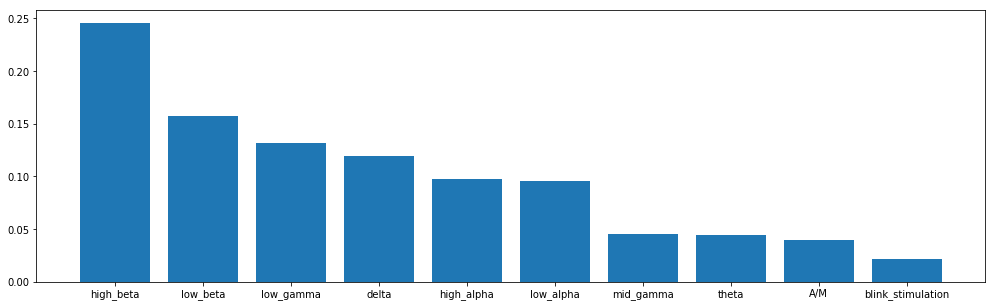

In [14]:
# random forest
train, test = train_test_split(df_subjects, test_size=0.2)
X = train.values[:,0:12]
Y = train.values[:,12]

X_test = test.values[:,0:12]
Y_test = test.values[:,12]
clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
clf.fit(X, Y)

# feature importance
features = []
importances = []
for importance, feature in reversed(sorted(zip(clf.feature_importances_, cols))):
    print(feature, importance)
    if (importance > 0):
        features.append(feature)
        importances.append(importance)
    
y_pos = np.arange(len(importances))
 
# Create bars
plt.bar(y_pos, importances)
plt.xticks(y_pos, features)
plt.show()

mean accuracy:  0.6807720520814231


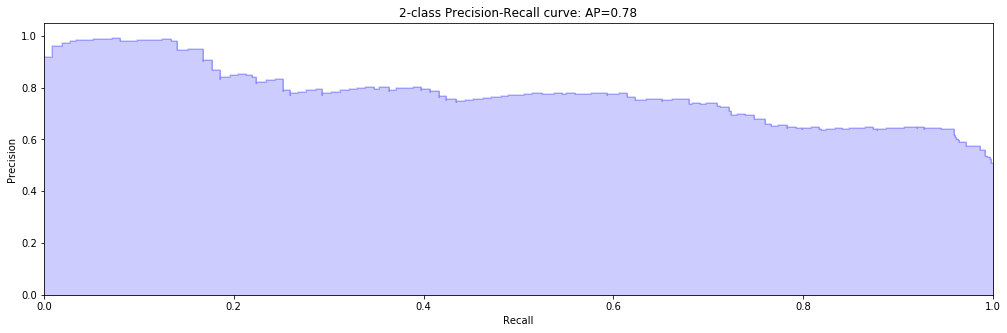

In [15]:
# accuracy
print("mean accuracy: ", clf.score(X_test, Y_test))
Y_scores = []
Y_scores = clf.predict_proba(X_test)[:,-1]
#print(Y_scores)

# cross validation
#scores = cross_val_score(clf, X, Y, cv=5)
#print("CV score:", scores)

# precision recall
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
average_precision = average_precision_score(Y_test, Y_scores)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [16]:
# perform grid search for best hyperparams (DO NOT UNCOMMENT UNLESS GRID SEARCH IS NEEDED)
#param_grid = { 
#    'n_estimators': [200, 500, 800],
#    'max_features': ['sqrt', 'log2', 'auto'],
#    'max_depth': [1, 2, 3]
#}
#CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
#CV_rfc.fit(X, Y)
#print(CV_rfc.best_params_)

mean accuracy:  0.8134971575279663
high_beta 0.19668101651359596
low_beta 0.1548198687349845
low_gamma 0.12192790958059396
delta 0.12167716816113507
high_alpha 0.09975765532191967
low_alpha 0.0859427677844248
theta 0.07105001753205872
A/M 0.054703288472328984
blink_stimulation 0.04884050098214386
mid_gamma 0.04455417069510476
A/M Other 4.5636221709507186e-05
blink_strength 0.0


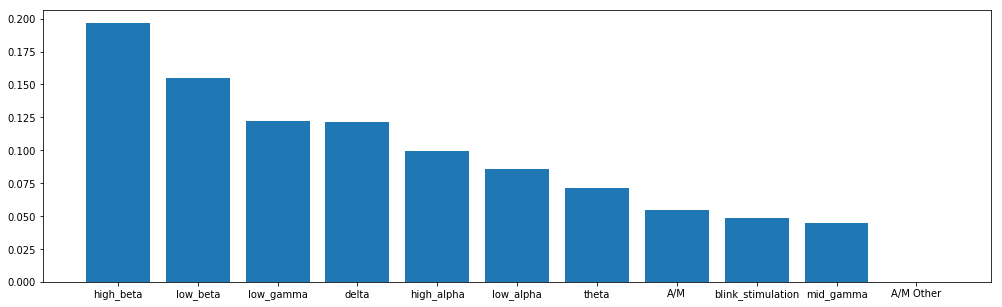

In [17]:
# random forest with grid searched hyperparams
clf = RandomForestClassifier(n_estimators=200, max_depth=3, max_features="auto", random_state=0)
clf.fit(X, Y)
print("mean accuracy: ", clf.score(X_test, Y_test))

# feature importance
features = []
importances = []
for importance, feature in reversed(sorted(zip(clf.feature_importances_, cols))):
    print(feature, importance)
    if (importance > 0):
        features.append(feature)
        importances.append(importance)
    
y_pos = np.arange(len(importances))
 
# Create bars
plt.bar(y_pos, importances)
plt.xticks(y_pos, features)
plt.show()

mean accuracy:  0.8134971575279663


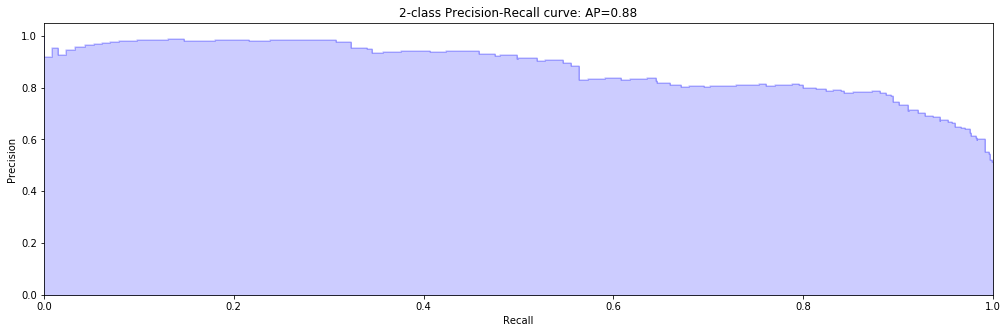

In [18]:
# accuracy
print("mean accuracy: ", clf.score(X_test, Y_test))
Y_scores = []
Y_scores = clf.predict_proba(X_test)[:,-1]
#print(Y_scores)

# cross validation
#scores = cross_val_score(clf, X, Y, cv=5)
#print("CV score:", scores)

# precision recall
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
average_precision = average_precision_score(Y_test, Y_scores)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

      high_beta  label
s1 0     9837.0      0
   1     9837.0      0
   2     9837.0      0
   3     9837.0      0
   4     9837.0      0
mean accuracy:  0.5568952869979827


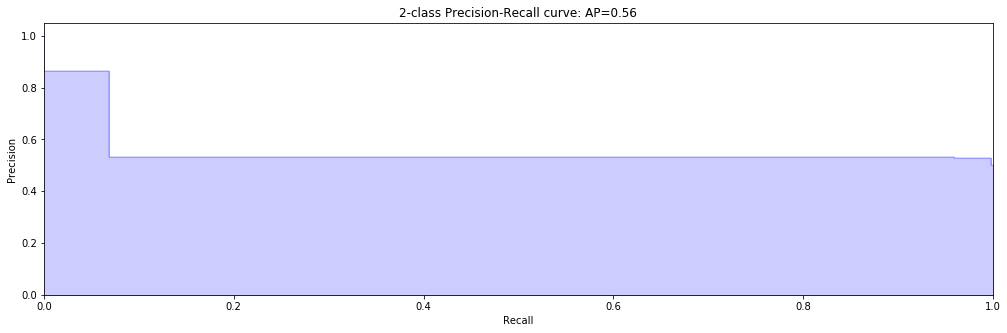

In [19]:
# random forest on beta waves
df_beta = df_subjects[['high_beta', 'label']]
print(df_beta.head())
train, test = train_test_split(df_beta, test_size=0.2)
X = train.values[:,0:1]
Y = train.values[:,1]

X_test = test.values[:,0:1]
Y_test = test.values[:,1]
clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
clf.fit(X, Y)

# accuracy
print("mean accuracy: ", clf.score(X_test, Y_test))
Y_scores = []
Y_scores = clf.predict_proba(X_test)[:,-1]
#print(Y_scores)

# cross validation
#scores = cross_val_score(clf, X, Y, cv=5)
#print("CV score:", scores)

# precision recall
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
average_precision = average_precision_score(Y_test, Y_scores)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

      high_beta  low_alpha  label
s1 0     9837.0    74006.0      0
   1     9837.0    74006.0      0
   2     9837.0    74006.0      0
   3     9837.0    74006.0      0
   4     9837.0    74006.0      0
mean accuracy:  0.5906840271410233


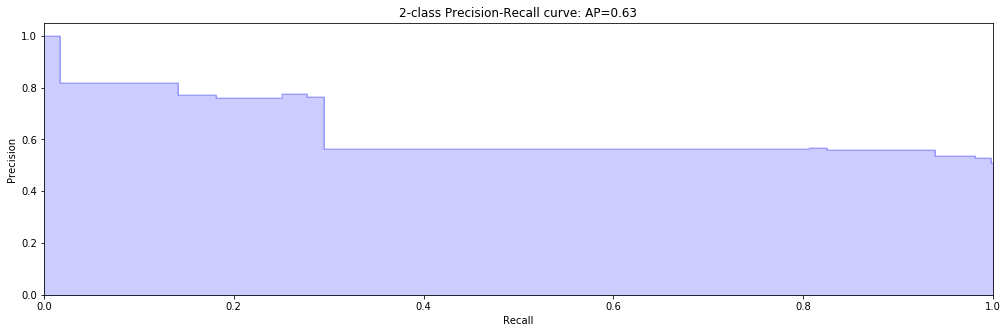

In [20]:
# random forest on beta waves
df_beta = df_subjects[['high_beta', 'low_alpha', 'label']]
print(df_beta.head())
train, test = train_test_split(df_beta, test_size=0.2)
X = train.values[:,0:2]
Y = train.values[:,2]

X_test = test.values[:,0:2]
Y_test = test.values[:,2]
clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
clf.fit(X, Y)

# accuracy
print("mean accuracy: ", clf.score(X_test, Y_test))
Y_scores = []
Y_scores = clf.predict_proba(X_test)[:,-1]
#print(Y_scores)

# cross validation
#scores = cross_val_score(clf, X, Y, cv=5)
#print("CV score:", scores)

# precision recall
precision, recall, thresholds = precision_recall_curve(Y_test, Y_scores)
average_precision = average_precision_score(Y_test, Y_scores)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

# testing on subject 2
train2, test2 = train_test_split(df_sub2, test_size=0.2)
X2 = train2.values[:,0:12]
Y2 = train2.values[:,12]

X_test2 = test2.values[:,0:12]
Y_test2 = test2.values[:,12]

clf.fit(X2, Y2)

# accuracy
print("mean accuracy: ", clf.score(X_test2, Y_test2))
Y_scores2 = []
Y_scores2 = clf.predict_proba(X_test2)[:,-1]
#print(Y_scores)


# cross validation
scores = cross_val_score(clf, X, Y, cv=5)
print("CV score:", scores)

precision, recall, thresholds = precision_recall_curve(Y_test2, Y_scores2)
average_precision = average_precision_score(Y_test2, Y_scores2)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()